In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
import h5py
import os 
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Softmax
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten 


import seaborn as sns
from IPython.display import display, Image, HTML
display(HTML("<style>.container { width:100% ; }</style>"))
%matplotlib inline


# Check if any GPU is detected
print("GPU(s) found: ")
print(tf.config.list_physical_devices('GPU'))

Using TensorFlow backend.


GPU(s) found: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Helper Functions

In [2]:
def get_tf_train_data(h5filename):
    hf = h5py.File('h5files/' + h5filename, 'r')
    X_tr = hf['X_tr'][:]
    X_vld = hf['X_vld'][:]
    lab_tr = hf['lab_tr'][:]
    lab_vld = hf['lab_vld'][:]
#     list_ch_train = hf['list_ch_train'][:]
    hf.close()
#     return X_tr, X_vld, lab_tr, lab_vld, list_ch_train
    return X_tr, X_vld, lab_tr, lab_vld

def get_tf_test_data(h5filename):
    hf = h5py.File('h5files/' + h5filename, 'r')
    X_test = hf['X_test'][:]
    y_test = hf['y_test'][:]
#     list_ch_test = hf['list_ch_test'][:]
#     return X_test, y_test, list_ch_test
    return X_test, y_test

def prediction_accuracy(ytest, predict_val):
    # rows belong to prediction
    # columns to test values
    # order BUY, NONE , SELL
    accuracy_mat = np.zeros([3,3], dtype = float)
    for i in range(ytest.shape[1]):
        for j in range(predict_val.shape[1]):
            accuracy_mat[i,j] = sum(predict_val[(predict_val[:,j] * ytest[:,i] > 0),j])
    allobs = sum(map(sum, accuracy_mat))
    accuracy_mat = np.divide(accuracy_mat, allobs)
    accuracy_mat = pd.DataFrame(accuracy_mat, columns = ['Buy', 'None', 'Sell'], index = ['Buy', 'None', 'Sell'])
    return accuracy_mat

In [3]:
# filenames used 
traindtfile = 'hdf_nonCryptos.h5'

# Model

In [ ]:
batch_size = 400 # Batch size
epochs = 300

def evaluate_model(trainX, trainy, testX, testy, epochs= epochs, batch_size = batch_size, verbose = 0):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=2, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=100, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling1D(pool_size=2, strides=2,))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])    
    
    # fit network
    history = model.fit(trainX, trainy, validation_split=0.25, epochs=epochs, batch_size=batch_size, verbose=verbose)
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    # evaluate model
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    probability_model = Sequential([model, Softmax()])
    
    predict_val = probability_model.predict(testX)
    x = np.argmax(predict_val, axis = 1)
    predict_valid = np.zeros(predict_val.shape)
    predict_valid[x == 0,0] = 1
    predict_valid[x == 1,1] = 1
    predict_valid[x == 2,2] = 1
    df = prediction_accuracy(testy, predict_valid)
    ax = sns.heatmap(df, annot=True,fmt='.2%', cmap='Blues')
    ax.xaxis.set_ticks_position('top')
    plt.show()
    
    return accuracy

def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
    

# run an experiment
def run_experiment(repeats=3):
    # load data
    trainX, testX, trainy, testy = get_tf_train_data(traindtfile)
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 

# Evaluation

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


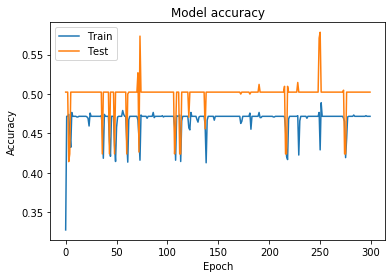

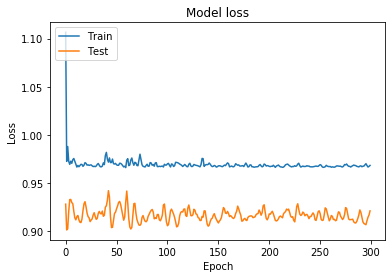

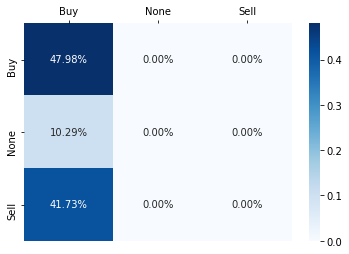

>#1: 47.978
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


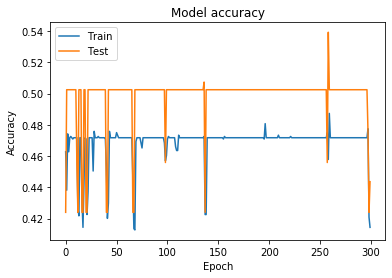

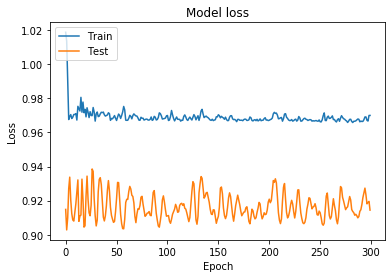

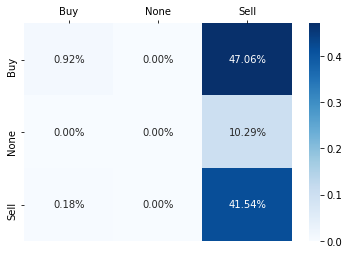

>#2: 42.463
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


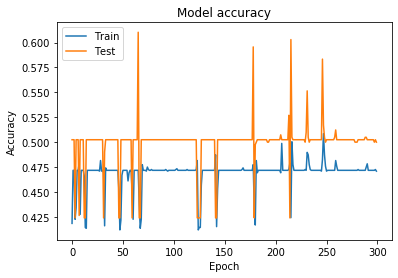

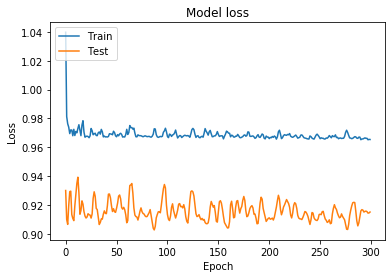

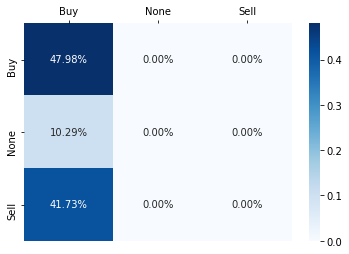

>#3: 47.978
[47.97794222831726, 42.463234066963196, 47.97794222831726]
Accuracy: 46.140% (+/-2.600)


In [4]:
# run the experiment
run_experiment()